In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype as Category
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
import numpy as np
from iterextras import par_for
import subprocess as sp
import os
import gc
import ujson
from pymer4.models import Lmer
from pickle_cache import PickleCache
import itertools
from tqdm.auto import tqdm
import rs_utils

pcache = PickleCache('.cache')

sns.set()

In [2]:
def cond(df, m=None, c=None, p=None):
    if m is not None:
        df = df[df.mutability_mode == m]
    if c is not None:
        df = df[df.context_mode == c]
    if p is not None:
        df = df[df.pointer_mode == p]
    return df

In [3]:
PATHS = glob('../data/*.json')
CRATES = [os.path.splitext(os.path.basename(path))[0] for path in PATHS]
CATEGORIES = {
    'mutability_mode': Category(["DistinguishMut", "IgnoreMut"]),
    'context_mode': Category(["Recurse", "SigOnly"]),
    'pointer_mode': Category(["Conservative", "Precise"]),
    'crate': Category(CRATES)
}

def parse_data(path):
    print(path)
    if os.stat(path).st_size == 0:
        return []
    
    crate = os.path.splitext(os.path.basename(path))[0]
    df = pd.DataFrame(rs_utils.parse_data(path))
    df['crate'] = crate
    for k, dt in CATEGORIES.items():
        df[k] = df[k].astype(dt)
    return df


gc.disable()
all_dfs = par_for(parse_data, PATHS)
df = pd.concat(all_dfs).reset_index()
del all_dfs
gc.enable()

df = df[(df.num_relevant_instructions != 0)]
df['ins_rel_nonzero'] = df.instructions_relative > 0

../data/rav1e.json../data/hyper.json
../data/image.json

../data/RustPython.json
../data/rg3d.json
../data/rayon.json
../data/rustls.json../data/Rocket.json

../data/nalgebra.json
../data/sccache.json


  0%|          | 0/10 [00:00<?, ?it/s]

In [4]:
len(df.function_path.unique())

14520

In [5]:
len(df)/8

416957.0

In [6]:
best_df = df[(df.mutability_mode == 'DistinguishMut') & (df.context_mode == 'Recurse') & (df.pointer_mode == 'Precise')]
best_df_over_z = best_df[best_df.instructions_relative > 0].sort_values(['num_instructions'])
len(best_df_over_z)

0

In [7]:
best_df_over_z

,index,mutability_mode,context_mode,pointer_mode,sliced_local,function_range,function_path,num_instructions,num_relevant_instructions,num_tokens,...,has_same_type_ptrs_in_call,has_same_type_ptrs_in_input,reached_library,instructions_relative,instructions_relative_frac,instructions_relative_base,instructions_relative_base_frac,baseline_reached_library,crate,ins_rel_nonzero


In [8]:
row = df.loc[151736]
df[(df.function_path == row.function_path) & (df.sliced_local == row.sliced_local)]

,index,mutability_mode,context_mode,pointer_mode,sliced_local,function_range,function_path,num_instructions,num_relevant_instructions,num_tokens,...,has_same_type_ptrs_in_call,has_same_type_ptrs_in_input,reached_library,instructions_relative,instructions_relative_frac,instructions_relative_base,instructions_relative_base_frac,baseline_reached_library,crate,ins_rel_nonzero
151736,151736,DistinguishMut,Recurse,Precise,375,"{'start_line': 199, 'start_col': 2, 'end_line'...",rav1e[8787]::cdef::rust::cdef_filter_block,1237,181,3110,...,False,False,True,0,0.0,0,0.0,True,rav1e,False
151737,151737,DistinguishMut,Recurse,Conservative,375,"{'start_line': 199, 'start_col': 2, 'end_line'...",rav1e[8787]::cdef::rust::cdef_filter_block,1237,181,3110,...,False,False,True,0,0.0,0,0.0,True,rav1e,False
151738,151738,DistinguishMut,SigOnly,Precise,375,"{'start_line': 199, 'start_col': 2, 'end_line'...",rav1e[8787]::cdef::rust::cdef_filter_block,1237,181,3110,...,False,False,True,0,0.0,0,0.0,True,rav1e,False
151739,151739,DistinguishMut,SigOnly,Conservative,375,"{'start_line': 199, 'start_col': 2, 'end_line'...",rav1e[8787]::cdef::rust::cdef_filter_block,1237,181,3110,...,False,False,True,0,0.0,0,0.0,True,rav1e,False
151740,151740,IgnoreMut,Recurse,Precise,375,"{'start_line': 199, 'start_col': 2, 'end_line'...",rav1e[8787]::cdef::rust::cdef_filter_block,1237,181,3110,...,False,False,True,0,0.0,0,0.0,True,rav1e,False
151741,151741,IgnoreMut,Recurse,Conservative,375,"{'start_line': 199, 'start_col': 2, 'end_line'...",rav1e[8787]::cdef::rust::cdef_filter_block,1237,181,3110,...,False,False,True,0,0.0,0,0.0,True,rav1e,False
151742,151742,IgnoreMut,SigOnly,Precise,375,"{'start_line': 199, 'start_col': 2, 'end_line'...",rav1e[8787]::cdef::rust::cdef_filter_block,1237,181,3110,...,False,False,True,0,0.0,0,0.0,True,rav1e,False
151743,151743,IgnoreMut,SigOnly,Conservative,375,"{'start_line': 199, 'start_col': 2, 'end_line'...",rav1e[8787]::cdef::rust::cdef_filter_block,1237,181,3110,...,False,False,True,0,0.0,0,0.0,True,rav1e,False


In [9]:
row.function_path

'rav1e[8787]::cdef::rust::cdef_filter_block'

In [10]:
row

index                                                                         151736
mutability_mode                                                       DistinguishMut
context_mode                                                                 Recurse
pointer_mode                                                                 Precise
sliced_local                                                                     375
function_range                     {'start_line': 199, 'start_col': 2, 'end_line'...
function_path                             rav1e[8787]::cdef::rust::cdef_filter_block
num_instructions                                                                1237
num_relevant_instructions                                                        181
num_tokens                                                                      3110
num_relevant_tokens                                                              207
duration                                                         

In [11]:
df = pcache.get('df', lambda: df, force=True)

In [12]:
df['ins_rel_frac_log'] = np.log(df.instructions_relative_frac)

/raid/wcrichto/rust-slicer/.env/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [13]:
df2 = df
df2 = df2[(df2.pointer_mode == 'Precise') & (df2.mutability_mode == 'IgnoreMut') & (df2.context_mode == 'SigOnly')]
df2[df2.num_instructions < 1000] \
    .sort_values('instructions_relative_base_frac', ascending=False)[df2.crate == 'nalgebra'][80:160:4] \
    [['function_range', 'function_path']]

/raid/wcrichto/rust-slicer/.env/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


,function_range,function_path
2923942,"{'start_line': 871, 'start_col': 4, 'end_line'...",nalgebra[8787]::geometry::dual_quaternion::{im...
3101654,"{'start_line': 879, 'start_col': 4, 'end_line'...",nalgebra[8787]::base::matrix::{impl#4}::zip_zi...
3125438,"{'start_line': 838, 'start_col': 4, 'end_line'...",nalgebra[8787]::base::blas::{impl#2}::gemm
2940478,"{'start_line': 114, 'start_col': 4, 'end_line'...",nalgebra[8787]::linalg::convolution::{impl#0}:...
3074566,"{'start_line': 563, 'start_col': 4, 'end_line'...",nalgebra[8787]::linalg::svd::{impl#1}::solve
2947470,"{'start_line': 687, 'start_col': 4, 'end_line'...",nalgebra[8787]::base::matrix::{impl#4}::zip_map
2999550,"{'start_line': 1583, 'start_col': 4, 'end_line...",nalgebra[8787]::base::matrix::{impl#23}::parti...
3122390,"{'start_line': 441, 'start_col': 4, 'end_line'...",nalgebra[8787]::base::blas::{impl#1}::xxgemv
3051246,"{'start_line': 71, 'start_col': 4, 'end_line':...",nalgebra[8787]::linalg::convolution::{impl#0}:...
3036318,"{'start_line': 788, 'start_col': 4, 'end_line'...",nalgebra[8787]::base::matrix::{impl#4}::zip_fold


In [14]:
df2 = df
df2 = df2[(df2.pointer_mode == 'Precise') & (df2.mutability_mode == 'IgnoreMut') & (df2.context_mode == 'SigOnly')]
df2[df2.num_instructions < 1000] \
    .sort_values('instructions_relative_base_frac', ascending=False)[df2.crate == 'Rocket'][df2.function_path.str.contains('new')]   

/raid/wcrichto/rust-slicer/.env/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


,index,mutability_mode,context_mode,pointer_mode,sliced_local,function_range,function_path,num_instructions,num_relevant_instructions,num_tokens,...,has_same_type_ptrs_in_input,reached_library,instructions_relative,instructions_relative_frac,instructions_relative_base,instructions_relative_base_frac,baseline_reached_library,crate,ins_rel_nonzero,ins_rel_frac_log
2805134,62134,IgnoreMut,SigOnly,Precise,2,"{'start_line': 104, 'start_col': 4, 'end_line'...",rocket[8787]::router::uri::{impl#0}::try_new,329,66,1166,...,False,False,65,65.0,65,65.0,False,Rocket,True,4.174387
2805126,62126,IgnoreMut,SigOnly,Precise,1,"{'start_line': 104, 'start_col': 4, 'end_line'...",rocket[8787]::router::uri::{impl#0}::try_new,329,66,1166,...,False,False,65,65.0,65,65.0,False,Rocket,True,4.174387
2805190,62190,IgnoreMut,SigOnly,Precise,9,"{'start_line': 104, 'start_col': 4, 'end_line'...",rocket[8787]::router::uri::{impl#0}::try_new,329,66,1166,...,False,False,64,32.0,64,32.0,False,Rocket,True,3.465736
2805182,62182,IgnoreMut,SigOnly,Precise,8,"{'start_line': 104, 'start_col': 4, 'end_line'...",rocket[8787]::router::uri::{impl#0}::try_new,329,66,1166,...,False,True,63,21.0,63,21.0,True,Rocket,True,3.044522
2798510,55510,IgnoreMut,SigOnly,Precise,3,"{'start_line': 39, 'start_col': 4, 'end_line':...",rocket[8787]::local::asynchronous::request::{i...,92,21,562,...,False,False,20,20.0,20,20.0,False,Rocket,True,2.995732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2815782,72782,IgnoreMut,SigOnly,Precise,19,"{'start_line': 159, 'start_col': 4, 'end_line'...",rocket[8787]::catcher::{impl#0}::new,86,4,1634,...,False,True,0,0.0,0,0.0,True,Rocket,False,-inf
2815790,72790,IgnoreMut,SigOnly,Precise,20,"{'start_line': 159, 'start_col': 4, 'end_line'...",rocket[8787]::catcher::{impl#0}::new,86,3,1634,...,False,True,0,0.0,0,0.0,True,Rocket,False,-inf
2815798,72798,IgnoreMut,SigOnly,Precise,21,"{'start_line': 159, 'start_col': 4, 'end_line'...",rocket[8787]::catcher::{impl#0}::new,86,2,1634,...,False,False,0,0.0,0,0.0,False,Rocket,False,-inf
2815638,72638,IgnoreMut,SigOnly,Precise,1,"{'start_line': 159, 'start_col': 4, 'end_line'...",rocket[8787]::catcher::{impl#0}::new,86,1,1634,...,False,False,0,0.0,0,0.0,False,Rocket,False,-inf


In [15]:
df2[(df2.function_path == 'nalgebra[8787]::linalg::full_piv_lu::{impl#2}::solve_mut') & df2.ins_rel_nonzero]

,index,mutability_mode,context_mode,pointer_mode,sliced_local,function_range,function_path,num_instructions,num_relevant_instructions,num_tokens,...,has_same_type_ptrs_in_input,reached_library,instructions_relative,instructions_relative_frac,instructions_relative_base,instructions_relative_base_frac,baseline_reached_library,crate,ins_rel_nonzero,ins_rel_frac_log
3051254,207334,IgnoreMut,SigOnly,Precise,0,"{'start_line': 182, 'start_col': 4, 'end_line'...",nalgebra[8787]::linalg::full_piv_lu::{impl#2}:...,152,10,1306,...,False,True,4,0.666667,4,0.666667,True,nalgebra,True,-0.405465
3051262,207342,IgnoreMut,SigOnly,Precise,1,"{'start_line': 182, 'start_col': 4, 'end_line'...",nalgebra[8787]::linalg::full_piv_lu::{impl#2}:...,152,23,1306,...,False,False,22,22.000000,22,22.000000,False,nalgebra,True,3.091042
3051270,207350,IgnoreMut,SigOnly,Precise,2,"{'start_line': 182, 'start_col': 4, 'end_line'...",nalgebra[8787]::linalg::full_piv_lu::{impl#2}:...,152,23,1306,...,False,True,6,0.352941,6,0.352941,True,nalgebra,True,-1.041454
3051310,207390,IgnoreMut,SigOnly,Precise,7,"{'start_line': 182, 'start_col': 4, 'end_line'...",nalgebra[8787]::linalg::full_piv_lu::{impl#2}:...,152,3,1306,...,False,False,1,0.500000,1,0.500000,False,nalgebra,True,-0.693147
3051334,207414,IgnoreMut,SigOnly,Precise,10,"{'start_line': 182, 'start_col': 4, 'end_line'...",nalgebra[8787]::linalg::full_piv_lu::{impl#2}:...,152,3,1306,...,False,False,1,0.500000,1,0.500000,False,nalgebra,True,-0.693147
3051470,207550,IgnoreMut,SigOnly,Precise,27,"{'start_line': 182, 'start_col': 4, 'end_line'...",nalgebra[8787]::linalg::full_piv_lu::{impl#2}:...,152,23,1306,...,False,False,22,22.000000,22,22.000000,False,nalgebra,True,3.091042
3051478,207558,IgnoreMut,SigOnly,Precise,28,"{'start_line': 182, 'start_col': 4, 'end_line'...",nalgebra[8787]::linalg::full_piv_lu::{impl#2}:...,152,23,1306,...,False,False,22,22.000000,22,22.000000,False,nalgebra,True,3.091042
3051486,207566,IgnoreMut,SigOnly,Precise,29,"{'start_line': 182, 'start_col': 4, 'end_line'...",nalgebra[8787]::linalg::full_piv_lu::{impl#2}:...,152,23,1306,...,False,False,22,22.000000,22,22.000000,False,nalgebra,True,3.091042
3051550,207630,IgnoreMut,SigOnly,Precise,37,"{'start_line': 182, 'start_col': 4, 'end_line'...",nalgebra[8787]::linalg::full_piv_lu::{impl#2}:...,152,6,1306,...,False,False,2,0.500000,2,0.500000,False,nalgebra,True,-0.693147
3051558,207638,IgnoreMut,SigOnly,Precise,38,"{'start_line': 182, 'start_col': 4, 'end_line'...",nalgebra[8787]::linalg::full_piv_lu::{impl#2}:...,152,5,1306,...,False,False,2,0.666667,2,0.666667,False,nalgebra,True,-0.405465


**Examples of big differences**

* modular vs whole-program
  * image (imageops/mod.rs:34) -- crop function passes &mut Image to container SubImage::new which doesn't modify the image, so recursing recognizes lack of mutation
    * rayon (slice/mod.rs:1139) -- passing pointer to container, same thing
  * rg3d (renderer/debug_renderer.rs:83) -- framebuffer.draw takes &mut self as input but doesn't safely mutate framebuffer, only indirectly through OpenGL calls
    * rg3d (renderer/shadow_map_renderer:443) -- same thing
    * image (buffer.rs:1115) -- unsafe pointer copying doesn't get registered as relevant during recurse
    * rustls (client/tls13.rs:1289) -- call to handle_new_ticket_tls13 has &mut input but mutation only happens behind
      inteior mutability, so not observed by recurse
  * nalgebra (linalg/full_piv_lu.rs:188) -- return value of function is a simple boolean that doesn't involve most inputs, but SigOnly conservatively assumes all inputs are relevant
    * nalgebra (sparse/cs_matrix_ops.rs:234) -- function influencing value of `nz` has many parameters, but only some actually influence its value, while SigOnly conservatively assumes all are relevant
* distinguish vs not mutation
  * rustls (quic.rs:156) -- iter() produces immut pts to vec, then ^= actually calls function BitXor::... which takes the immut ptr and could naively modify it. Recurse doesn't help b/c ^= is stdlib function.
  * rocket (router/collider.rs:159) -- immut ptrs to fields are recursively passed to functions that could naively modify them. Recurse doesn't help b/c called funcs are trait methods and not resolves.
  * image (codecs/pnm/decoder.rs:80) -- format has many functions that read data
  * rg3d (renderer/sruface.rs:445) -- `data.transform_geometry(transform)` takes immut ptr to transform, but naively could be modified, so `data` is relevant and whole function contributes to `data`
* conservative vs precise
  * image (codecs/gif.rs:458) -- function call causes lifetime to get equal to static, hence aliasing all function data, and has non-intuitive flow-insensitive effects
  * rg3d (resource/fbx/scene/mod.rs:145) -- two inputs could alias, and therefore mutations are indistinguishable
  * rustls (msgs/handshake.rs:70) -- opaque.clone_from_slice(bytes), implicit (&mut opaque) is assumed to alias bytes and bytes is a slice of Reader, therefore mutation

In [16]:
row = df.loc[2920242]
row.function_path
#df[(df.function_path == row.function_path) & (df.sliced_local == row.sliced_local)]

'nalgebra[8787]::geometry::reflection::{impl#1}::reflect_rows_with_sign'

# Dataset summary

## Lines of code

In [17]:
def compute_loc(grp):
    rng = grp.iloc[0].function_range
    return rng['end_line'] - rng['start_line'] + 1

total_loc = df.groupby('function_path').apply(compute_loc).sum()
total_loc

173108

In [18]:
#df2 = df.groupby(['crate', 'function_path']).apply(compute_loc)#.groupby('crate').sum()
g = df2.reset_index().groupby('crate')
out = g.sum()
out['size'] = g.size()
out

,level_0,index,sliced_local,num_instructions,num_relevant_instructions,num_tokens,num_relevant_tokens,duration,has_immut_ptr_in_call,has_same_type_ptrs_in_call,has_same_type_ptrs_in_input,reached_library,instructions_relative,instructions_relative_frac,instructions_relative_base,instructions_relative_base_frac,baseline_reached_library,ins_rel_nonzero,ins_rel_frac_log,size
crate,,,,,,,,,,,,,,,,,,,,
rav1e,22300792890,22300792890,52811907,266981680,15705901,661841304,26351437,419.318226,62113,13468,2766,47012,1253901,147695.661890,1155620,144945.789346,47012,32428,-inf,74667
hyper,30278330958,6396240342,10412967,67687149,15365995,148768736,4699127,2837.644041,38050,34332,0,33227,12747056,506102.413616,12746656,505821.551663,33227,29101,-inf,39981
image,40846267142,5839802542,2530439,16092296,1698447,222064530,2237633,47.494027,30671,7541,99,24966,314197,49559.855999,281297,48847.432356,24966,11731,-inf,38165
RustPython,151879686508,35996033932,10758040,82849265,5655863,649238360,5908763,4230.210036,92014,5542,22,65615,3148716,696815.306922,3142700,694367.502064,65615,49338,-inf,94722
rg3d,135335717196,14787388332,4320166,29494959,3740925,3203346875,6946122,435.493981,45762,4568,199,37997,1235615,98379.052403,1000408,89908.967648,37997,22209,-inf,60798
rayon,26458185418,445331978,228909,1517848,221161,19323245,340216,2.160454,7209,2092,102,4313,16771,6970.564484,14676,6822.127554,4313,2777,-inf,10535
rustls,62654655932,2240830076,1505035,10091781,1642992,93939640,2353469,158.113195,22172,8152,384,16366,874276,74216.443744,859324,73418.755216,16366,12514,-inf,23658
Rocket,35239523130,636578130,1091190,6535880,1267582,21539144,557092,381.941209,10904,994,0,7578,1062377,86763.760484,1062319,86751.344302,7578,6242,-inf,12615
nalgebra,111150204642,5518484082,2841392,16375065,1423878,115128767,1920042,16.513535,34198,501,108,21070,237280,56677.455623,197554,56204.636211,21070,17687,-inf,37143


In [19]:
df.groupby('function_path').apply(lambda df: df.iloc[0].num_instructions).sum()

1327257

In [20]:
1327257.0

1327257.0

## Execution time

In [21]:
df.duration.sum() / (3600 * 24)

0.8563702239970071

In [22]:
# sns.histplot(df.duration[::10])

In [163]:
times = df.groupby('context_mode').duration.sum() / (3600 * 24)
times

context_mode
Recurse    0.493736
SigOnly    0.362635
Name: duration, dtype: float64

In [198]:
df2 = cond(df, m='DistinguishMut', c='SigOnly', p='Precise')
print(df2.duration.max(), df2.duration.median() * 100000)


1.1169678444 109.03493999999999


In [199]:
df2 = cond(df, m='IgnoreMut', c='Recurse', p='Conservative')
print(df2.duration.max(), df2.duration.median() * 100000)

2.879440879 194.02275


In [170]:
df.groupby('context_mode').duration.max()

context_mode
Recurse    2.879441
SigOnly    1.385869
Name: duration, dtype: float64

In [168]:
df.groupby('context_mode').duration.describe()

,count,mean,std,min,25%,50%,75%,max
context_mode,,,,,,,,
Recurse,1667828.0,0.025577,0.105537,0.000002,0.000331,0.001574,0.009087,2.879441
SigOnly,1667828.0,0.018786,0.090032,0.000002,0.000283,0.001233,0.005552,1.385869


In [24]:
times['Recurse'] / (times['Recurse'] + times['SigOnly'])

0.5765445639053565

In [25]:
df.iloc[df.duration.argmax()]

index                                                                         631029
mutability_mode                                                            IgnoreMut
context_mode                                                                 Recurse
pointer_mode                                                            Conservative
sliced_local                                                                      99
function_range                     {'start_line': 1529, 'start_col': 0, 'end_line...
function_path                           rustpython_vm[8787]::stdlib::os::make_module
num_instructions                                                                 401
num_relevant_instructions                                                         89
num_tokens                                                                     15800
num_relevant_tokens                                                              117
duration                                                         

## Number of slices per function

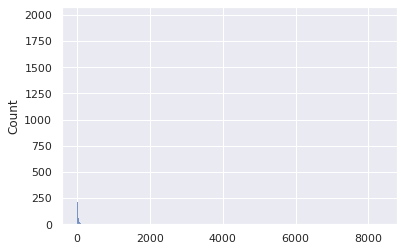

In [26]:
ax = sns.histplot((df.groupby('function_path').size() / 8))
# ax.set_yscale('log')
# ax.set_xscale('log')

In [27]:
len(df) / 8

416957.0

In [28]:
(df.groupby('crate').size() / 8)

crate
rav1e         74667.0
hyper         39981.0
image         38165.0
RustPython    94722.0
rg3d          60798.0
rayon         10535.0
rustls        23658.0
Rocket        12615.0
nalgebra      37143.0
sccache       24673.0
dtype: float64

## Number of instructions

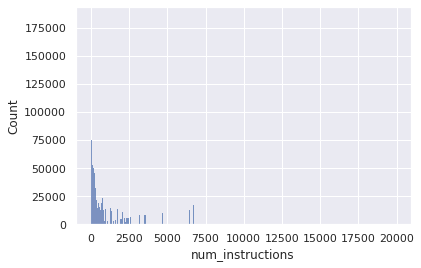

In [29]:
ax = sns.histplot(df.num_instructions)
# ax.set_xscale('log')

In [30]:
df_big = df[df.num_instructions >= 1000]
len(df_big) / len(df)

0.2396386198097166

## Timing

In [31]:
df.groupby(['crate', 'context_mode']).duration.describe()[['count', 'mean', 'std', '50%']]

count      mean       std       50%
crate      context_mode                                        
rav1e      Recurse       298668.0  0.009707  0.029409  0.001279
           SigOnly       298668.0  0.005134  0.010520  0.001168
hyper      Recurse       159924.0  0.054820  0.120390  0.013240
           SigOnly       159924.0  0.040581  0.110859  0.010586
image      Recurse       152660.0  0.001714  0.003062  0.000574
           SigOnly       152660.0  0.001189  0.001819  0.000509
RustPython Recurse       378888.0  0.063868  0.192126  0.007657
           SigOnly       378888.0  0.050199  0.165447  0.003267
rg3d       Recurse       243192.0  0.012658  0.043973  0.001276
           SigOnly       243192.0  0.006845  0.025428  0.001152
rayon      Recurse        42140.0  0.000275  0.000744  0.000045
           SigOnly        42140.0  0.000195  0.000413  0.000040
rustls     Recurse        94632.0  0.013216  0.029372  0.002466
           SigOnly        94632.0  0.006611  0.010517  0.001920
Rocket     Recurse        50460.0  0.016744  0.053903  0.000967
           SigOnly        50460.0  0.016071  0.052799  0.000854
nalgebra   Recurse       148572.0  0.000846  0.001943  0.000241
           SigOnly       148572.0  0.000416  0.000767  0.000168
sccache    Recurse        98692.0  0.012374  0.051854  0.001326
           SigOnly        98692.0  0.009485  0.040907  0.001117

# Relationship between source features and conditions

## Mutability


In [32]:
df2 = df[(df.mutability_mode == 'IgnoreMut') & (df.context_mode == 'Recurse') & (df.pointer_mode == 'Precise')]
cnts = df2.groupby(['has_immut_ptr_in_call', 'ins_rel_nonzero']).instructions_relative.describe()
cnts[['count']] / len(df2)

count
has_immut_ptr_in_call ins_rel_nonzero          
False                 False            0.120996
                      True             0.000115
True                  False            0.425185
                      True             0.453704

In [33]:
# First example was where immediate function didn't have immut ptrs, but a nested call did
df2 = df[~df.has_immut_ptr_in_call]
df2 = df2[(df2.mutability_mode == 'IgnoreMut') & (df2.context_mode == 'Recurse') & (df2.pointer_mode == 'Precise')]
df2[df2.instructions_relative > 0]

,index,mutability_mode,context_mode,pointer_mode,sliced_local,function_range,function_path,num_instructions,num_relevant_instructions,num_tokens,...,has_same_type_ptrs_in_input,reached_library,instructions_relative,instructions_relative_frac,instructions_relative_base,instructions_relative_base_frac,baseline_reached_library,crate,ins_rel_nonzero,ins_rel_frac_log
56428,56428,IgnoreMut,Recurse,Precise,13,"{'start_line': 1565, 'start_col': 2, 'end_line...",rav1e[8787]::rate::{impl#5}::twopass_out,86,29,7296,...,False,True,11,0.611111,11,6.111111e-01,True,rav1e,True,-0.492476
56436,56436,IgnoreMut,Recurse,Precise,14,"{'start_line': 1565, 'start_col': 2, 'end_line...",rav1e[8787]::rate::{impl#5}::twopass_out,86,28,7296,...,False,True,11,0.647059,11,6.470588e-01,True,rav1e,True,-0.435318
56492,56492,IgnoreMut,Recurse,Precise,21,"{'start_line': 1565, 'start_col': 2, 'end_line...",rav1e[8787]::rate::{impl#5}::twopass_out,86,29,7296,...,False,True,15,1.071429,15,1.071429e+00,True,rav1e,True,0.068993
56500,56500,IgnoreMut,Recurse,Precise,22,"{'start_line': 1565, 'start_col': 2, 'end_line...",rav1e[8787]::rate::{impl#5}::twopass_out,86,28,7296,...,False,True,15,1.153846,15,1.153846e+00,True,rav1e,True,0.143101
320660,320660,IgnoreMut,Recurse,Precise,0,"{'start_line': 1558, 'start_col': 0, 'end_line...",rav1e[8787]::encoder::encode_block_pre_cdef,159,54,16359,...,False,True,1,0.018868,0,0.000000e+00,True,rav1e,True,-3.970292
320684,320684,IgnoreMut,Recurse,Precise,3,"{'start_line': 1558, 'start_col': 0, 'end_line...",rav1e[8787]::encoder::encode_block_pre_cdef,159,53,16359,...,False,True,1,0.019231,0,0.000000e+00,True,rav1e,True,-3.951244
320692,320692,IgnoreMut,Recurse,Precise,4,"{'start_line': 1558, 'start_col': 0, 'end_line...",rav1e[8787]::encoder::encode_block_pre_cdef,159,44,16359,...,False,True,1,0.023256,18446744073709551615,4.099276e+17,True,rav1e,True,-3.761200
320732,320732,IgnoreMut,Recurse,Precise,9,"{'start_line': 1558, 'start_col': 0, 'end_line...",rav1e[8787]::encoder::encode_block_pre_cdef,159,53,16359,...,False,True,1,0.019231,0,0.000000e+00,True,rav1e,True,-3.951244
320820,320820,IgnoreMut,Recurse,Precise,20,"{'start_line': 1558, 'start_col': 0, 'end_line...",rav1e[8787]::encoder::encode_block_pre_cdef,159,53,16359,...,False,True,1,0.019231,0,0.000000e+00,True,rav1e,True,-3.951244
320868,320868,IgnoreMut,Recurse,Precise,26,"{'start_line': 1558, 'start_col': 0, 'end_line...",rav1e[8787]::encoder::encode_block_pre_cdef,159,53,16359,...,False,True,1,0.019231,0,0.000000e+00,True,rav1e,True,-3.951244


## Pointers

In [34]:
df['has_same_type_mut_ptrs'] = df.has_same_type_ptrs_in_call | df.has_same_type_ptrs_in_input
df2 = df[(df.mutability_mode == 'DistinguishMut') & (df.context_mode == 'Recurse') & \
              (df.pointer_mode == 'Conservative')]
cnts = df2.groupby(['has_same_type_mut_ptrs','ins_rel_nonzero', ]) \
    .instructions_relative.describe()
cnts[['count']] / len(df2)

count
has_same_type_mut_ptrs ins_rel_nonzero          
False                  False            0.798464
                       True             0.000218
True                   False            0.198793
                       True             0.002525

In [35]:
df2 = df #[(~df.has_same_type_ptrs_in_call) & (df.has_same_type_ptrs_in_input)]
df2 = df2[(df2.mutability_mode == 'DistinguishMut') & (df2.context_mode == 'Recurse') & \
              (df2.pointer_mode == 'Conservative')]
cnts = df2.groupby(['has_same_type_ptrs_in_input','ins_rel_nonzero', ]) \
    .instructions_relative.describe()
cnts[['count']] / len(df2)

count
has_same_type_ptrs_in_input ins_rel_nonzero          
False                       False            0.988066
                            True             0.001921
True                        False            0.009190
                            True             0.000823

In [36]:
df2 = df[(~df.has_same_type_ptrs_in_call) & (~df.has_same_type_ptrs_in_input)]
df2 = df2[(df2.mutability_mode == 'DistinguishMut') & (df2.context_mode == 'Recurse') & (df2.pointer_mode == 'Conservative')]
df2[df2.instructions_relative > 0]

,index,mutability_mode,context_mode,pointer_mode,sliced_local,function_range,function_path,num_instructions,num_relevant_instructions,num_tokens,...,reached_library,instructions_relative,instructions_relative_frac,instructions_relative_base,instructions_relative_base_frac,baseline_reached_library,crate,ins_rel_nonzero,ins_rel_frac_log,has_same_type_mut_ptrs
260417,260417,DistinguishMut,Recurse,Conservative,16,"{'start_line': 1107, 'start_col': 4, 'end_line...",rav1e[8787]::predict::rust::pred_directional::...,322,17,8797,...,True,6,0.545455,6,0.545455,True,rav1e,True,-0.606136,False
260425,260425,DistinguishMut,Recurse,Conservative,17,"{'start_line': 1107, 'start_col': 4, 'end_line...",rav1e[8787]::predict::rust::pred_directional::...,322,16,8797,...,True,6,0.600000,6,0.600000,True,rav1e,True,-0.510826,False
260433,260433,DistinguishMut,Recurse,Conservative,18,"{'start_line': 1107, 'start_col': 4, 'end_line...",rav1e[8787]::predict::rust::pred_directional::...,322,15,8797,...,True,6,0.666667,6,0.666667,True,rav1e,True,-0.405465,False
260441,260441,DistinguishMut,Recurse,Conservative,19,"{'start_line': 1107, 'start_col': 4, 'end_line...",rav1e[8787]::predict::rust::pred_directional::...,322,11,8797,...,False,6,1.200000,6,1.200000,False,rav1e,True,0.182322,False
260449,260449,DistinguishMut,Recurse,Conservative,20,"{'start_line': 1107, 'start_col': 4, 'end_line...",rav1e[8787]::predict::rust::pred_directional::...,322,13,8797,...,True,6,0.857143,6,0.857143,True,rav1e,True,-0.154151,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2562481,8849,DistinguishMut,Recurse,Conservative,19,"{'start_line': 128, 'start_col': 4, 'end_line'...",rustls[8787]::msgs::handshake::{impl#4}::read,137,33,10062,...,True,18,1.200000,18,1.200000,True,rustls,True,0.182322,False
2716377,162745,DistinguishMut,Recurse,Conservative,162,"{'start_line': 623, 'start_col': 4, 'end_line'...",rustls[8787]::msgs::handshake::{impl#23}::read,777,30,10062,...,True,2,0.071429,2,0.071429,True,rustls,True,-2.639057,False
2716409,162777,DistinguishMut,Recurse,Conservative,166,"{'start_line': 623, 'start_col': 4, 'end_line'...",rustls[8787]::msgs::handshake::{impl#23}::read,777,30,10062,...,True,2,0.071429,2,0.071429,True,rustls,True,-2.639057,False
2739337,185705,DistinguishMut,Recurse,Conservative,107,"{'start_line': 783, 'start_col': 4, 'end_line'...",rustls[8787]::msgs::handshake::{impl#26}::read,518,30,10062,...,True,2,0.071429,2,0.071429,True,rustls,True,-2.639057,False


## Context

In [37]:
df2 = df[(df.mutability_mode == 'DistinguishMut') & (df.context_mode == 'SigOnly') & (df.pointer_mode == 'Precise')]
df2.groupby(['ins_rel_nonzero', 'baseline_reached_library']).num_relevant_instructions.describe()

count        mean         std  \
ins_rel_nonzero baseline_reached_library                                     
False           False                     139695.0    3.469301    6.621981   
                True                      258263.0   90.200102  279.896656   
True            False                        732.0   26.874317   55.467475   
                True                       18267.0  184.707396  215.121801   

                                          min   25%   50%     75%     max  
ins_rel_nonzero baseline_reached_library                                   
False           False                     1.0   1.0   2.0    4.00   516.0  
                True                      2.0  11.0  27.0   67.00  3515.0  
True            False                     3.0   6.0  11.0   36.25   817.0  
                True                      3.0  41.0  99.0  254.00  1282.0

In [38]:
# g = sns.FacetGrid(data=df2, col='baseline_reached_library', col_wrap=5, sharex=False)
# g.map_dataframe(plot_ins_nz)

# Slice size analysis

In [39]:
def plot_ins(data, xscale='linear', yscale='linear', field='instructions_relative_frac', nz=True, ax=None, **kwargs):
    if xscale == 'log':
        df_plot = data[data.ins_rel_nonzero]
        bins = np.logspace(np.log10(0.00001), np.log10(df_plot[field].max()))
    elif xscale == 'symlog':
        df_plot = data
        min_n = df_plot[df_plot[field] > 0][field].min()/10
        bins = np.concatenate(([0], np.logspace(np.log10(min_n), np.log10(df_plot[field].max()))))
    else:
        df_plot = data
        n = df_plot.instructions_relative_frac.max()
        bins = np.arange(0, n, n / 50)
        
    ax = sns.histplot(df_plot[field], bins=bins, ax=ax) #element='step')
    ax.set_yscale(yscale)
    if xscale == 'symlog':
        ax.set_xscale(xscale, linthresh=min_n, linscale=0.2)
    else:
        ax.set_xscale(xscale)
        
    ax.set_xlabel('\% diff in slice size' + (', log scale' if 'log' in xscale else ''))
    ax.set_ylabel('Count' + (', log scale' if yscale == 'log' else ''))
    
    if xscale == 'log' and nz:
        n = data[data.ins_rel_nonzero][field].min() / 10
        ax.bar(n, len(data[~data.ins_rel_nonzero]), color='r', width=[n])
    elif xscale == 'symlog':
        ax.set_xlim(0)
        xticks = ax.get_xticks()
        ax.set_xticks(np.concatenate((xticks[0:1], xticks[3:])))
        
plot_ins_nz = lambda *args, **kwargs: plot_ins(*args, xscale='log', yscale='linear', nz=False, **kwargs)
plot_ins_abs = lambda *args, **kwargs: plot_ins(*args, field='instructions_relative', **kwargs)

# plot_ins(df, 'symlog', 'log')

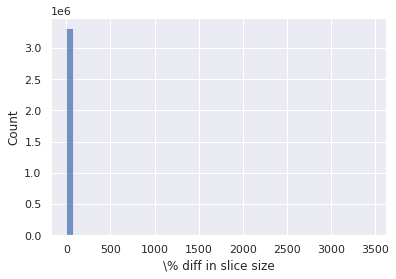

In [40]:
plot_ins(df, 'linear', 'linear')

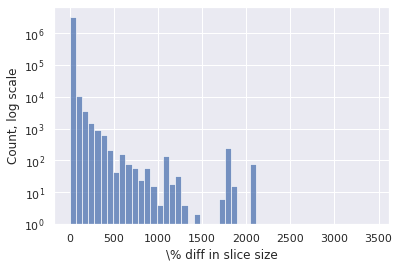

In [41]:
plot_ins(df, 'linear', 'log')

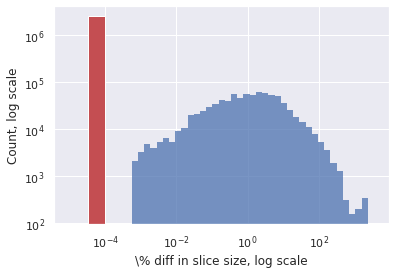

In [42]:
plot_ins(df, 'log', 'log')

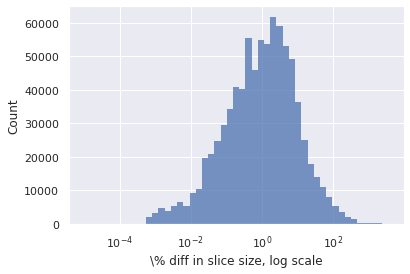

In [43]:
plot_ins_nz(df)

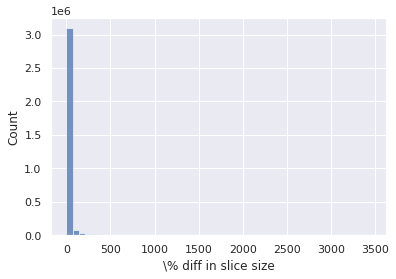

In [44]:
plot_ins_abs(df)

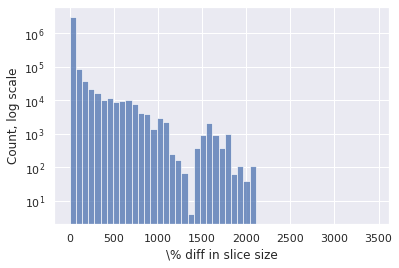

In [45]:
plot_ins_abs(df, yscale='log')

In [46]:
df2 = df[(df.pointer_mode == 'Precise') & (df.context_mode == 'SigOnly') & (df.mutability_mode == 'DistinguishMut')]
df2[df2.ins_rel_nonzero].groupby('crate').size()

crate
rav1e         5906
hyper          213
image         1763
RustPython    1923
rg3d          3961
rayon          408
rustls        2005
Rocket          37
nalgebra      1599
sccache       1184
dtype: int64

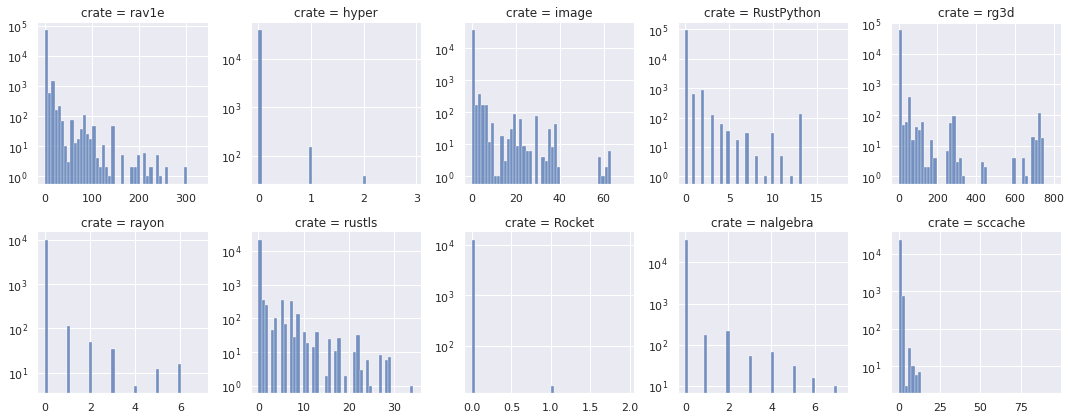

In [47]:
g = sns.FacetGrid(data=df[(df.pointer_mode == 'Precise') & (df.context_mode == 'SigOnly') & (df.mutability_mode == 'DistinguishMut')], 
                  col='crate', col_wrap=5, sharey=False, sharex=False)
g.map_dataframe(plot_ins_abs, yscale='log')

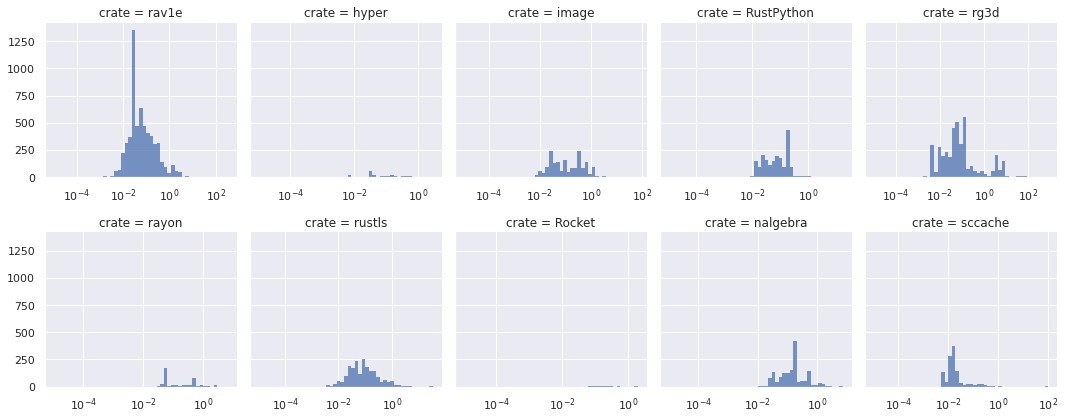

In [48]:
g = sns.FacetGrid(data=df[(df.pointer_mode == 'Precise') & (df.context_mode == 'SigOnly') & (df.mutability_mode == 'DistinguishMut')], 
                  col='crate', col_wrap=5, sharex=False)
g.map_dataframe(plot_ins, xscale='log', nz=False)

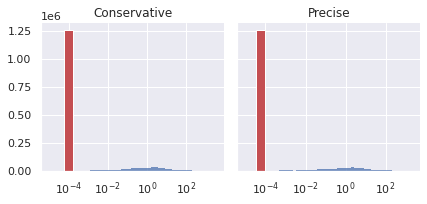

In [49]:
g = sns.FacetGrid(data=df, col='pointer_mode', sharex=False)
g.map_dataframe(plot_ins, xscale='log')
g.set_titles('{col_name}')

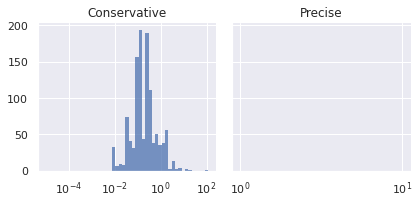

In [50]:
g = sns.FacetGrid(data=df[(df.mutability_mode == 'DistinguishMut') & (df.context_mode == 'Recurse')], 
                  col='pointer_mode', sharex=False)
g.map_dataframe(plot_ins, xscale='log', nz=False)
g.set_titles('{col_name}')

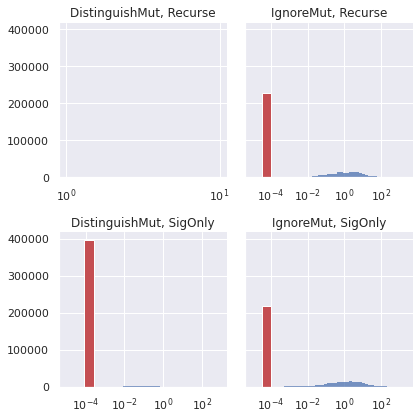

In [51]:
g = sns.FacetGrid(data=df[df.pointer_mode == 'Precise'], col='mutability_mode', row='context_mode', sharex=False)
g.map_dataframe(plot_ins, xscale='log')
g.set_titles('{col_name}, {row_name}')

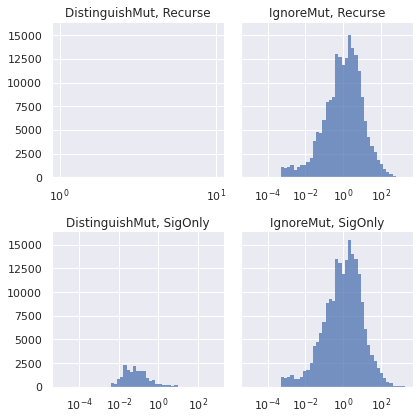

In [52]:
g = sns.FacetGrid(data=df[df.pointer_mode == 'Precise'], col='mutability_mode', row='context_mode', sharex=False)
g.map_dataframe(plot_ins, xscale='log', nz=False)
g.set_titles('{col_name}, {row_name}')

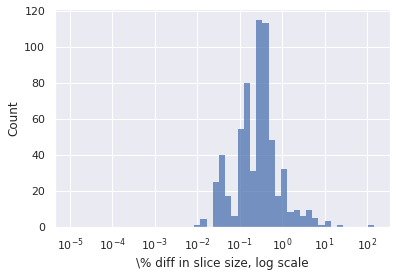

In [53]:
plot_ins(cond(df, c='SigOnly', m='DistinguishMut', p='Conservative'), field='instructions_relative_base_frac', 
         xscale='log', nz=False)

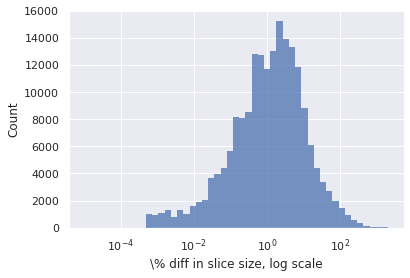

In [54]:
plot_ins(cond(df, c='SigOnly', m='IgnoreMut', p='Precise'), field='instructions_relative_base_frac', 
         xscale='log', nz=False)



# Final plots for paper

/raid/wcrichto/rust-slicer/.env/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


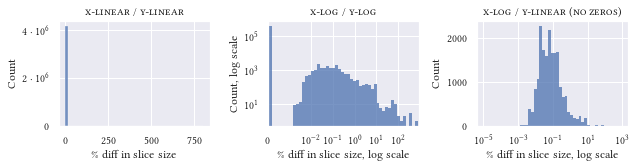

In [321]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Linux Libertine O']})
rc('text', **{'usetex': True, 'latex.preamble': r'\usepackage{libertine}\usepackage[libertine]{newtxmath}'})

df2 = cond(df, c='SigOnly', m='DistinguishMut', p='Precise')
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(9, 2.5))
plot_ins(df2, ax=ax1)
ax1.set_title('\\textsc{x-linear / y-linear}')
ax1.set_yticklabels(['0', '$2 \cdot 10^6$', '$4 \cdot 10^6$'])
# plot_ins(cond(df, c='SigOnly', m='DistinguishMut', p='Precise'), yscale='log', ax=ax2)
# ax2.set_title('\\textsc{x-linear / y-log}')
plot_ins(df2, xscale='symlog', yscale='log', ax=ax2)
ax2.set_title('\\textsc{x-log / y-log}')
plot_ins(df2, xscale='log', nz=False, ax=ax3)
ax3.set_title('\\textsc{x-log / y-linear (no zeros)}')
ax3.set_xticks([10e-6, 10e-4, 10e-2, 10e-0, 10e2])
# fig.suptitle('Distribution of slice \%diff for SigOnly vs. Recurse')
fig.tight_layout()
fig.savefig('eval-recurse-dist.pdf')

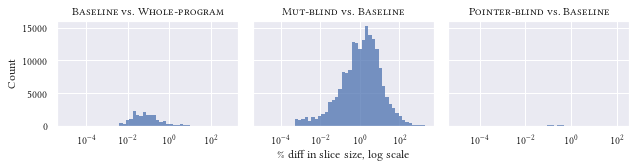

In [58]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(9, 2.5), sharey=True)

plot_ins(cond(df, c='SigOnly', m='DistinguishMut', p='Precise'), xscale='log', nz=False, ax=ax1)
ax1.set_title('\\textsc{Baseline} vs. \\textsc{Whole-program}')
plot_ins(cond(df, c='SigOnly', m='IgnoreMut', p='Precise'), field='instructions_relative_base_frac', 
         xscale='log', nz=False, ax=ax2)
ax2.set_title('\\textsc{Mut-blind} vs. \\textsc{Baseline}')
plot_ins(cond(df, c='SigOnly', m='DistinguishMut', p='Conservative'), field='instructions_relative_base_frac', 
         xscale='log', nz=False, ax=ax3)
ax3.set_title('\\textsc{Pointer-blind} vs. \\textsc{Baseline}')

ax1.set_xlabel('')
ax3.set_xlabel('')

fig.tight_layout()

fig.savefig('eval-all-dist.pdf')

In [229]:
df2 = cond(df, c='SigOnly', m='IgnoreMut', p='Precise')
g = df2[df2.instructions_relative_base_frac > 0].groupby('crate').size().rename('nz')
g2 = pd.concat([
    g, 
    df2.groupby('crate').size().rename('total'), 
    df2.groupby('crate').num_instructions.median().rename('avg_ins')], axis=1)
g2['frac'] = g2.nz / g2.total
g2.sort_values('frac')

,nz,total,avg_ins,frac
crate,,,,
rayon,2404,10535,45,0.228192
image,10370,38165,280,0.271715
rg3d,20825,60798,179,0.342528
rav1e,29404,74667,965,0.393802
nalgebra,16908,37143,187,0.455214
Rocket,6210,12615,145,0.492271
rustls,12004,23658,213,0.507397
RustPython,48495,94722,227,0.511972
sccache,15370,24673,414,0.622948


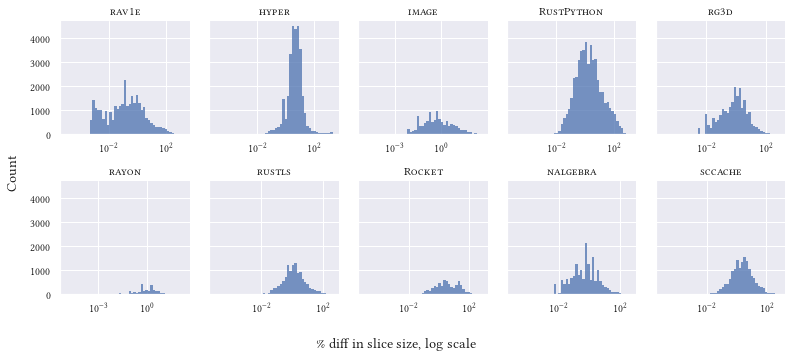

In [220]:
g = sns.FacetGrid(data=cond(df, c='SigOnly', m='IgnoreMut', p='Precise'), 
                  col='crate', col_wrap=5, sharex=False, height=2.5, aspect=0.9)
g.map_dataframe(plot_ins, xscale='log', nz=False, field='instructions_relative_base_frac')
g.set_titles('\\textsc{{{col_name}}}')
g.fig.supylabel('Count')
g.fig.supxlabel('\% diff in slice size, log scale')
g.fig.tight_layout()
g.fig.savefig('eval-crates.pdf')

In [59]:
from scipy.stats.mstats import gmean

df2 = cond(df, c='SigOnly', m='IgnoreMut', p='Precise')
nz = df2[df2.instructions_relative_base_frac > 0]
print(len(nz) / len(df2), gmean(nz.instructions_relative_base_frac))

0.4579560961921733 1.0321631535999034


In [60]:
df2 = cond(df, c='SigOnly', m='DistinguishMut', p='Conservative')
nz = df2[df2.instructions_relative_base_frac > 0]
print(len(nz) / len(df2), gmean(nz.instructions_relative_base_frac))

0.0015013538566326983 0.25346777731474607


In [66]:
cond(df, c='Recurse', m='DistinguishMut', p='Precise').groupby('reached_library').num_instructions.describe()

,count,mean,std,min,25%,50%,75%,max
reached_library,,,,,,,,
False,140427.0,1139.470999,3423.611977,2.0,34.0,133.0,541.0,19915.0
True,276530.0,1282.745930,2791.607510,3.0,164.0,445.0,1173.0,19915.0


In [69]:
140427 / (140427 + 276530)

0.66320987535885

In [63]:
cond(df, c='SigOnly', m='DistinguishMut', p='Precise').groupby(['reached_library', 'ins_rel_nonzero']) \
    .instructions_relative_frac.describe()[['count', 'mean', '50%']]

count      mean       50%
reached_library ins_rel_nonzero                              
False           False            139695.0  0.000000  0.000000
                True                732.0  7.059228  0.500000
True            False            258263.0  0.000000  0.000000
                True              18267.0  0.328048  0.060998

In [71]:
print(732 / 139695)
print(18267.0 / 258263.0)

0.005239987114785783
0.07073022461599222


In [312]:
# df2 = cond(df, c='SigOnly', m='DistinguishMut', p='Precise')
# df3 = df2.groupby(['crate', 'function_path']) \
#     .apply(lambda df: df.iloc[0]).reset_index(drop=True)
num_slices = df2.groupby(['crate']).size().rename('num_slices')
avg_ins_per_func = df3.groupby('crate').num_instructions.mean() \
    .rename('avg_ins_per_func')
num_funcs = df2.groupby(['crate']).size().rename('num_funcs')

q = df2.groupby(['crate', 'function_path']).size()
avg_slices_per_func = q[q > 0] \
    .groupby('crate').mean().rename('avg_slices_per_func')
pd.concat(
    [num_slices, avg_ins_per_func, num_funcs, avg_slices_per_func], 
    axis=1).sort_values('num_slices')

,num_slices,avg_ins_per_func,num_funcs,avg_slices_per_func
crate,,,,
rayon,10535,30.650000,10535,9.938679
Rocket,12615,52.948718,12615,17.024291
rustls,23658,87.943548,23658,27.255760
sccache,24673,128.332815,24673,38.371695
nalgebra,37143,60.998319,37143,20.808403
image,38165,116.569113,38165,36.382269
hyper,39981,163.256962,39981,50.608861
rg3d,60798,55.270882,60798,17.632831
rav1e,74667,248.662037,74667,86.420139
